# Natural Language Processing with Disaster Tweets
#### Overview

In this project, we will be creating an algorithm to categorize and identify Tweets. First, we will examine and explore the data, then we will use machine learning and natural language processing models to classify disaster and non-disaster Tweets. The NLP dataset contains labeled tweets for training and a test set on which the model will be evaluated.

Natural Language Processing (NLP) is a field within machine learning, that works to teach computers how to analyze and learn human language. Its scope encompasses various tasks, from breaking down text into words to identifying emotions and facilitating language translation. Combining machine learning techniques with linguistic principles, NLP gives rise to applications like chatbots and language translation tools. Just as image data demands specialized preprocessing steps, text data undergoes its own set of preparatory techniques, including practices like tokenization, which we'll delve into shortly.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Input, Embedding, Bidirectional, GRU, Dense, Attention
from keras.models import Model
train  = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
print(train.head())
print(train.shape)
print(test.shape)

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
(7613, 5)
(3263, 4)


### Exploratory Data Analysis
The columns in the datset are:

ID: a unique identifier for each tweet
Keyword: the keyword from the tweet
Location: the location of origin of the tweet
Text: the whole text of the tweet
Target: true labels 1 or 0 (A 1 means that the tweet is about a real disaster and 0 means it is not)

We can see that there are 7,613 Tweets in the training dataset and 3,263 Tweets in the test dataset. 

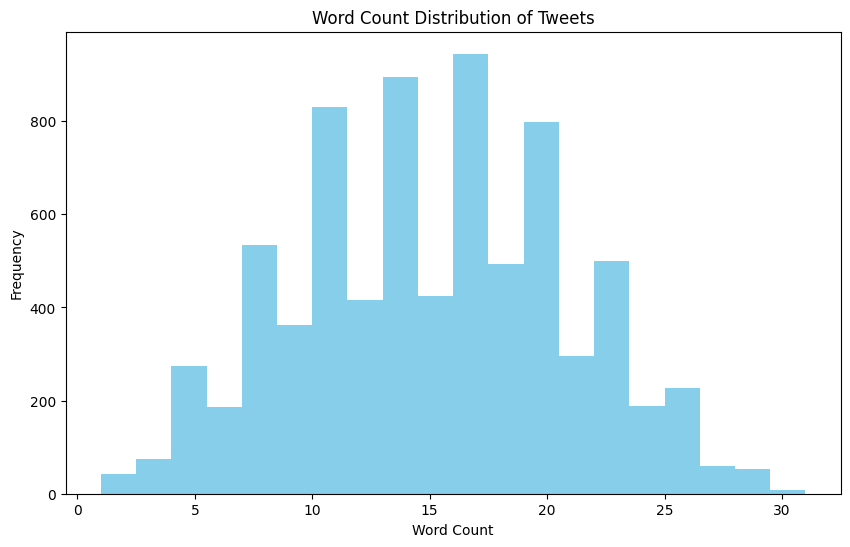

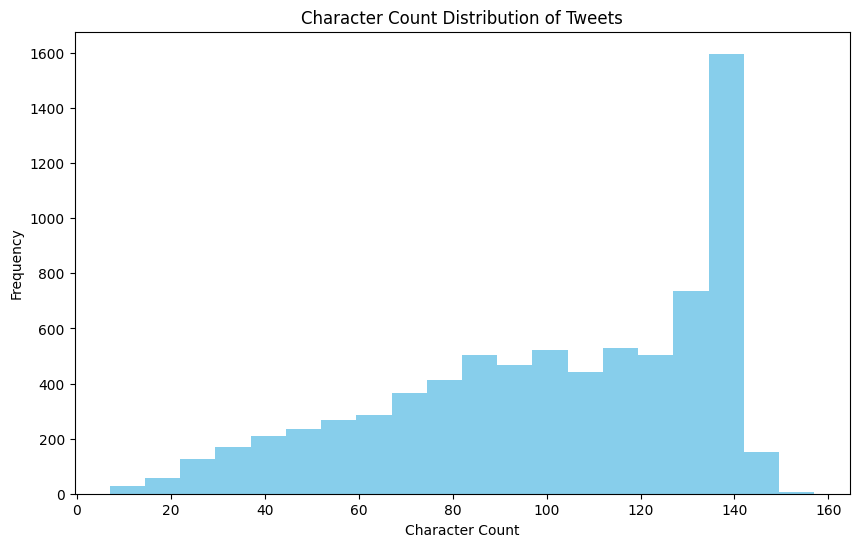

In [4]:
# calculate word count for each tweet
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
plt.hist(train['word_count'], bins=20, color='skyblue')
plt.title('Word Count Distribution of Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# calculate character count for each tweet
train['char_count'] = train['text'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(train['char_count'], bins=20, color='skyblue')
plt.title('Character Count Distribution of Tweets')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

In [5]:
train.describe()

,id,target,word_count,char_count
count,7613.000000,7613.00000,7613.000000,7613.000000
mean,5441.934848,0.42966,14.903586,101.037436
std,3137.116090,0.49506,5.732604,33.781325
min,1.000000,0.00000,1.000000,7.000000
25%,2734.000000,0.00000,11.000000,78.000000
50%,5408.000000,0.00000,15.000000,107.000000
75%,8146.000000,1.00000,19.000000,133.000000
max,10873.000000,1.00000,31.000000,157.000000


The word count distribution looks like a normal distribution and there doesn't seem to be many outliers. Most of the Tweets consist of 10 to 20 words. 

The character count distribution skews left and most Tweets seem to have upwards 130 characters. 

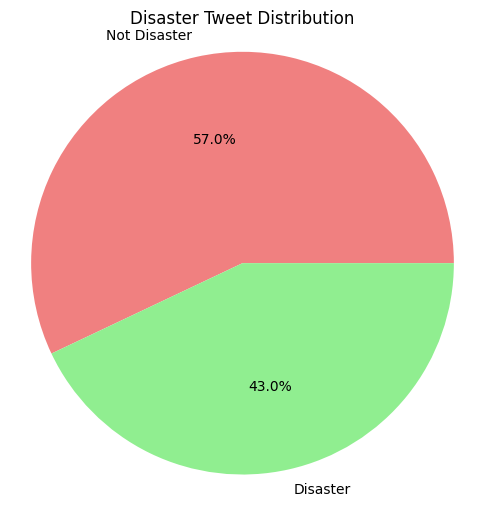

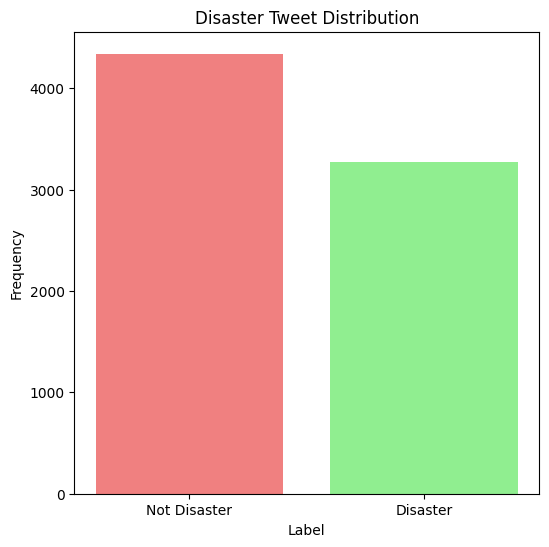

In [6]:
disaster_counts = train['target'].value_counts()

# pie chart
plt.figure(figsize=(6, 6))
plt.pie(disaster_counts, labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Disaster Tweet Distribution')
plt.axis('equal')
plt.show()

# histogram
plt.figure(figsize=(6, 6))
plt.bar(disaster_counts.index, disaster_counts.values, color=['lightcoral', 'lightgreen'])
plt.title('Disaster Tweet Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(disaster_counts.index, ['Not Disaster', 'Disaster'])
plt.show()

We can see that there are more Not Disaster Tweets than Disaster Tweets, which could pose as a source of bias in our model but the difference isn't too large.

Next, we will be cleaning the dataset and removing some less relevant information from the Tweets like stopwords and punctuation. Then, we will be converting all the characters to lower case to have uniformity and better comparability.

In [7]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    return ' '.join([i for i in text.split() if i not in STOPWORDS])

def remove_less_than(text, minNumberOfChars):
    return ' '.join([i for i in text.split() if len(i) >= minNumberOfChars])

def convert_to_lower(text):
    return text.lower()

In [8]:
# clean training data
train['text'] = train['text'].apply(lambda text: remove_punctuation(text))
train['text'] = train['text'].apply(lambda text: remove_stopwords(text))
train['text'] = train['text'].apply(lambda text: remove_less_than(text, 3))
train['text'] = train['text'].apply(lambda text: convert_to_lower(text))


# clean test data
test['text'] = test['text'].apply(lambda text: remove_punctuation(text))
test['text'] = test['text'].apply(lambda text: remove_stopwords(text))
test['text'] = test['text'].apply(lambda text: remove_less_than(text, 3))
test['text'] = test['text'].apply(lambda text: convert_to_lower(text))

print(train['text'][42])

had awesome time visiting cfc head office ancop site ablaze thanks tita vida taking care


Now that our data is cleaned up, we can move on to:

### Data Preprocessing

First, we'll do some tokenization on the cleaned text data, and then we'll explore different word embedding methods, and lastly, split the data into training and validation sets for use in a model like LSTM. In addition to this, we also haveo to make sure that it is in the proper format for our model input.

Tokenization is the process of breaking down a sequence of text into individual units (typically words) which are then called tokens. These tokens can be seen as the features for our models and help us work with a normalized and standardized text data.

We will be using some word embedding methods that are a type of word representation technique to represent words as continuous, dense vectors in a multi-dimensional space. These word vectors allow algorithms to understand and work with language data more effectively. Word2Vec, which learns word embeddings by training a neural network on a large corpus of text. It generates dense, continuous-valued word vectors that even capture semantic relationships between words.

In [9]:
train['tokens'] = train['text'].apply(lambda text: word_tokenize(text))
test['tokens'] = test['text'].apply(lambda text: word_tokenize(text))

In [10]:
# define Word2Vec model
word2vec_model = Word2Vec(train['tokens'].tolist(), vector_size=100, 
                          window=5, min_count=1, sg=0, workers=4)

# convert tokens to Word2Vec vectors
def tokens_to_vectors(tokens, word2vec_model):
    vectors = []
    for token in tokens:
        if token in word2vec_model.wv:
            vectors.append(word2vec_model.wv[token])
    return vectors

train['word2vec_vectors'] = train['tokens'].apply(lambda x: tokens_to_vectors(x, word2vec_model))
test['word2vec_vectors'] = test['tokens'].apply(lambda x: tokens_to_vectors(x, word2vec_model))

In [11]:
# split the dataset
X = train['word2vec_vectors'] 
y = train['target']           

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test['word2vec_vectors']

We will only be looking at the text , id, and target portion of the dataset. To start, we will be building a LSTM model based on our word embedding and tune some hyperparameters. Then, after building this model and an alternate one, we will compare the two and select the best model based on the training results.

### Model Architecture

First up is our LSTM model. The model architecture consists of two LSTM layers followed by a dense output layer. The first LSTM layer processes sequences and returns sequences, while the second LSTM layer processes the sequence and returns a single output per sequence. The model is optimized for binary classification tasks and makes use of an Adam optimizer.

In [12]:
max_sequence_length = 30 #longest tweet length
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
X_val_padded = pad_sequences(X_val, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

In [13]:
def create_lstm_model(learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(128, input_shape=(max_sequence_length, word2vec_model.vector_size), return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=20, batch_size=32)

Epoch 1/20
191/191 [==============================] - 14s 53ms/step - loss: 0.6812 - accuracy: 0.5591 - val_loss: 0.6916 - val_accuracy: 0.5653
Epoch 2/20
191/191 [==============================] - 9s 48ms/step - loss: 0.6716 - accuracy: 0.5690 - val_loss: 0.6776 - val_accuracy: 0.5404
Epoch 3/20
191/191 [==============================] - 9s 49ms/step - loss: 0.6599 - accuracy: 0.6026 - val_loss: 0.6393 - val_accuracy: 0.6389
Epoch 4/20
191/191 [==============================] - 9s 48ms/step - loss: 0.6470 - accuracy: 0.6125 - val_loss: 0.6228 - val_accuracy: 0.6671
Epoch 5/20
191/191 [==============================] - 9s 49ms/step - loss: 0.6168 - accuracy: 0.6594 - val_loss: 0.6265 - val_accuracy: 0.6467
Epoch 6/20
191/191 [==============================] - 9s 49ms/step - loss: 0.5994 - accuracy: 0.6693 - val_loss: 0.5933 - val_accuracy: 0.6789
Epoch 7/20
191/191 [==============================] - 9s 48ms/step - loss: 0.5959 - accuracy: 0.6783 - val_loss: 0.5943 - val_accuracy: 0.680

In [15]:
def plot_training_results(history, model_name):   

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    epochs = range(1, len(training_loss) + 1)
    plt.figure(figsize=(12, 4))

    # training vs validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title(model_name + ': Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # training vs validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title(model_name + ': Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

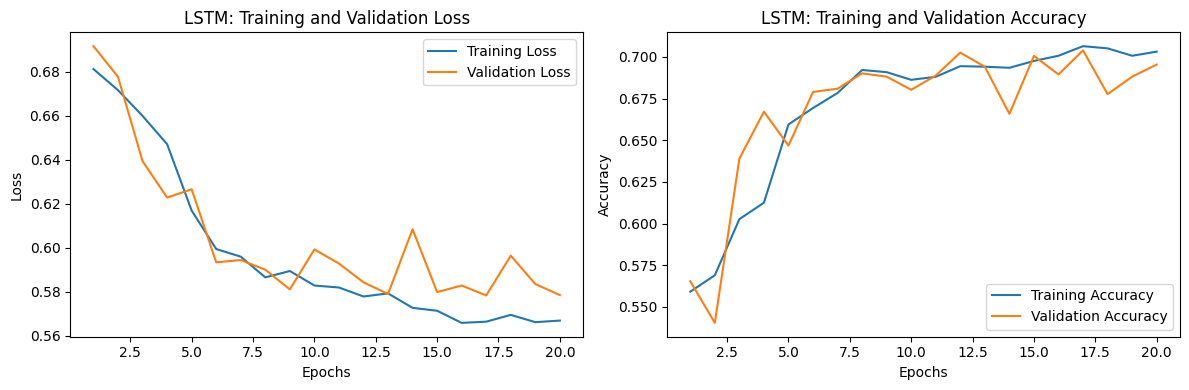

In [16]:
plot_training_results(lstm_history, "LSTM")

As seen in our plots, the training accuracy increases over time and loss decreases. We see that the training accuracy peaks around 70% after 20 epoch, which is pretty good!

For our next model, we're going to try a Bidirectional GRU. It can process input sequences in both the forward and backward directions, which differs from the last LSTM model which could only process input sequences unidirectionally.

In [17]:
embedding_dim = 100
hidden_units = 64

# iput layer
sequence_input = Input(shape=(max_sequence_length, embedding_dim), dtype='float32')

# bdirectional GRU layer
bi_gru = Bidirectional(GRU(hidden_units, return_sequences=True))(sequence_input)

# atention mechanism
attention = Attention()([bi_gru, bi_gru])
attended_gru = tf.keras.layers.Multiply()([bi_gru, attention])
pooling = tf.keras.layers.GlobalMaxPooling1D()(attended_gru)

# otput layer
output = Dense(1, activation='sigmoid')(pooling)

# ceate the model
bigru_model = Model(inputs=sequence_input, outputs=output)
optimizer = Adam(learning_rate=0.001)
bigru_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

bigru_history = bigru_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), 
                                epochs=20, batch_size=120)

Epoch 1/20
51/51 [==============================] - 6s 58ms/step - loss: 0.6889 - accuracy: 0.5635 - val_loss: 0.6834 - val_accuracy: 0.5739
Epoch 2/20
51/51 [==============================] - 2s 44ms/step - loss: 0.6832 - accuracy: 0.5695 - val_loss: 0.6846 - val_accuracy: 0.5739
Epoch 3/20
51/51 [==============================] - 2s 46ms/step - loss: 0.6836 - accuracy: 0.5695 - val_loss: 0.6804 - val_accuracy: 0.5739
Epoch 4/20
51/51 [==============================] - 2s 44ms/step - loss: 0.6773 - accuracy: 0.5685 - val_loss: 0.6792 - val_accuracy: 0.5404
Epoch 5/20
51/51 [==============================] - 2s 46ms/step - loss: 0.6737 - accuracy: 0.5737 - val_loss: 0.6648 - val_accuracy: 0.5890
Epoch 6/20
51/51 [==============================] - 2s 46ms/step - loss: 0.6681 - accuracy: 0.5846 - val_loss: 0.6580 - val_accuracy: 0.6021
Epoch 7/20
51/51 [==============================] - 2s 45ms/step - loss: 0.6512 - accuracy: 0.6167 - val_loss: 0.6302 - val_accuracy: 0.6487
Epoch 8/20
51

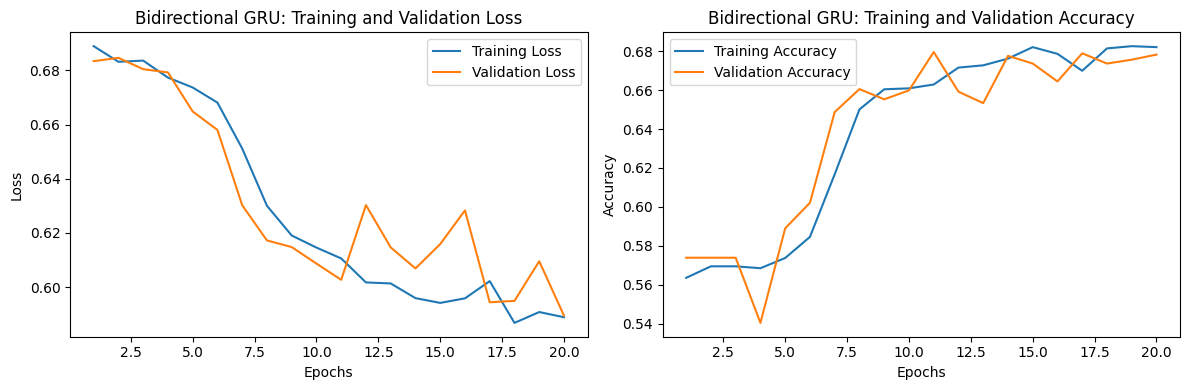

In [18]:
plot_training_results(bigru_history, "Bidirectional GRU")

Well, we didn't see too much of a difference between the two models. Both peaked around 70% but the LSTM model converged faster.

There could be several reasons why the GRU model did not show any improvement over the LSTM model. Some tasks with relatively short sequences or simple patterns, may not benefit significantly from bidirectional modeling.

Based on this, we will proceed with the LSTM model. 

In [19]:
# predict on test data
y_pred = lstm_model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)
submission = pd.DataFrame({'id': test['id'], 'target': y_pred_binary.flatten()})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 2s 17ms/step


## Conclusion

We experimented with two different models and selected the best one based on the training results to predict our test labels. That ended up being the LSTM model. Both the LSTM model and the Bidirectional GRU model performed similarly but the LSTM model performed slighly better. 

In the future, there are many different methods for representing text data and word embedding in order to enable models to work with it (e.g. One-Hot Encoding, GloVe (Global Vectors for Word Representation)) to try and see if that would improve the model. 